In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from tempfile import TemporaryFile
import psycopg2
import json

### 1 - Aquisição dos dados através do postgresql

In [4]:
credenciais = json.load(open('./credentials.json', 'r'))

In [5]:
connection = psycopg2.connect(**credenciais)
cursor = connection.cursor()
tmpfile = TemporaryFile('w+')
cursor.copy_expert('COPY (SELECT * FROM pca_data) TO STDOUT WITH CSV HEADER;', tmpfile)
tmpfile.seek(0)
df_exemplo = pd.read_csv(tmpfile, sep=',')
df_exemplo

OperationalError: connection to server at "127.0.0.1", port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?


In [ ]:
df_exemplo = pd.read_csv('./data/example_data1.csv')

In [ ]:
final_df = df_exemplo.copy()

### 2 - Análise dos dados

<AxesSubplot:>

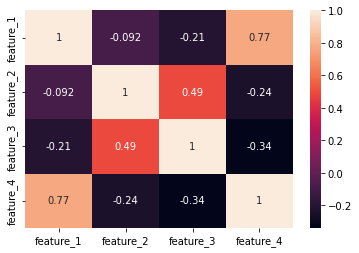

In [ ]:
sns.heatmap(df_exemplo.corr(), annot=True)

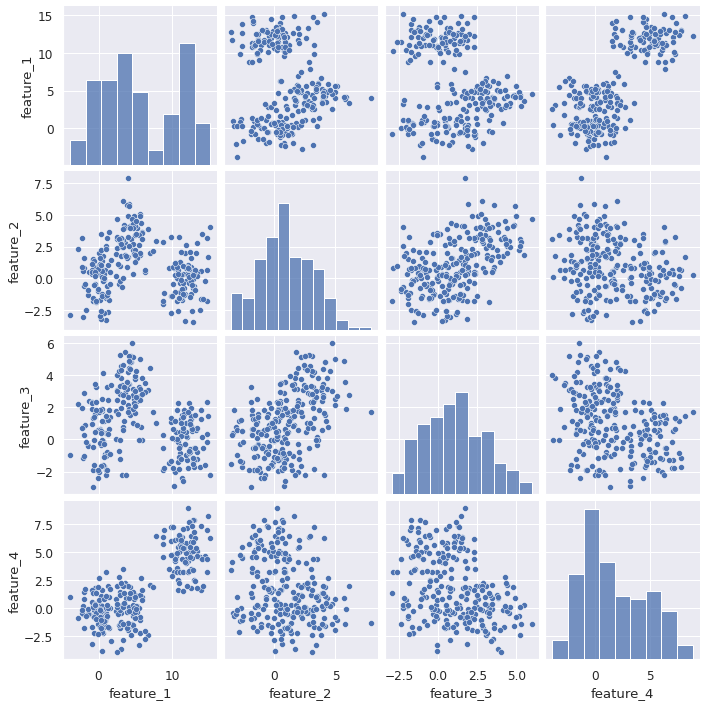

In [ ]:
sns.set(font_scale=1.1)
sns.pairplot(df_exemplo)

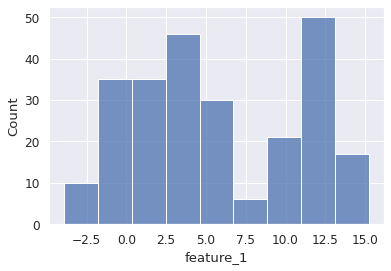

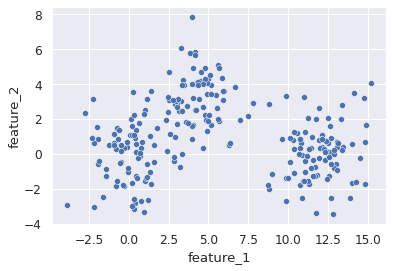

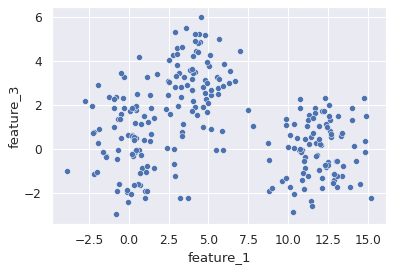

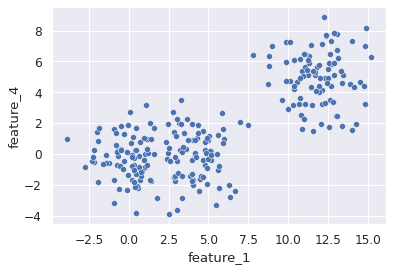

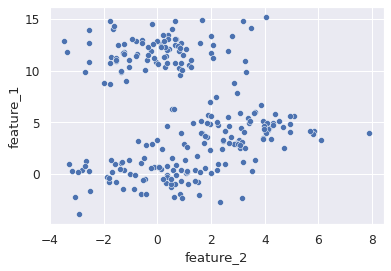

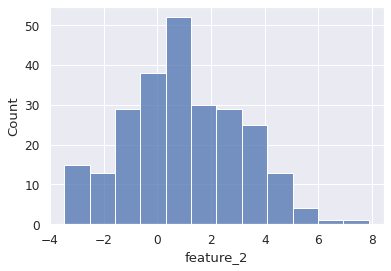

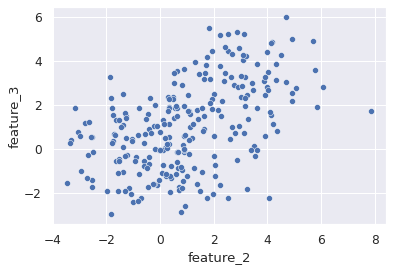

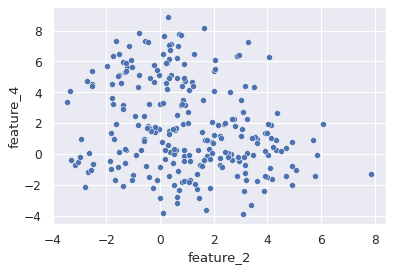

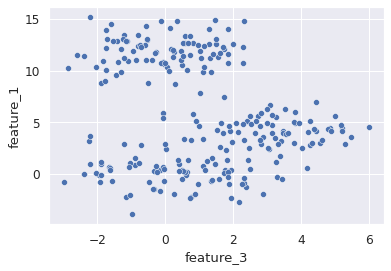

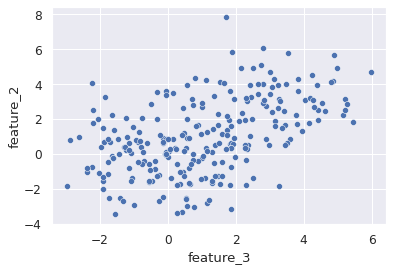

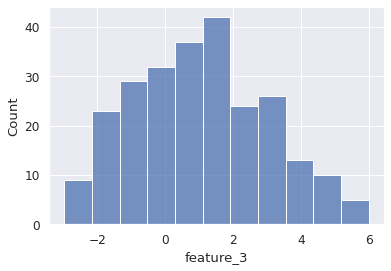

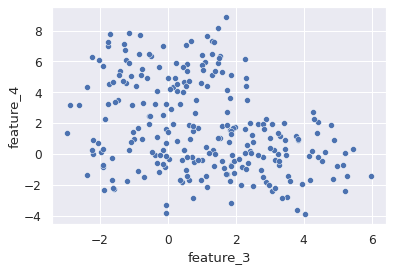

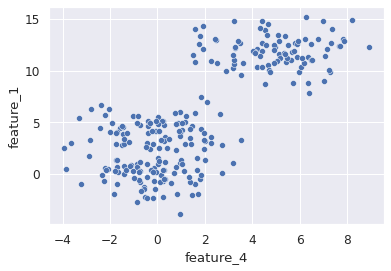

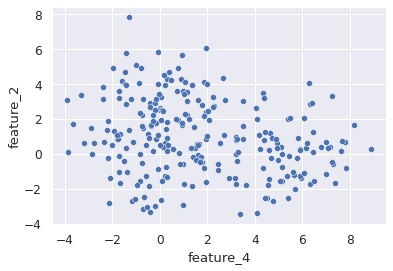

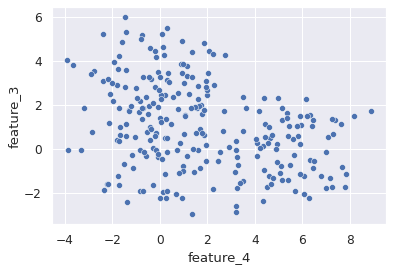

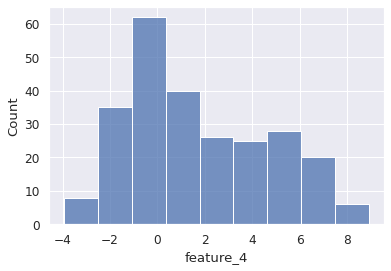

In [ ]:
for f_1 in df_exemplo.columns:
    for f_2 in df_exemplo.columns:
        if(f_1 != f_2):
            sns.scatterplot(data=df_exemplo, x=f_1, y=f_2)
        else:
            sns.histplot(data=df_exemplo, x=f_1)
        plt.savefig(f'imagens/{f_1}-{f_2}.png')
        plt.show()

### 3 - Normalização 

In [ ]:
std = StandardScaler()
normalized_df = pd.DataFrame(std.fit_transform(df_exemplo), columns=df_exemplo.columns)

### 4 - Modelo de aprendizado (K médias)

Text(0, 0.5, 'Variação intra-cluster')

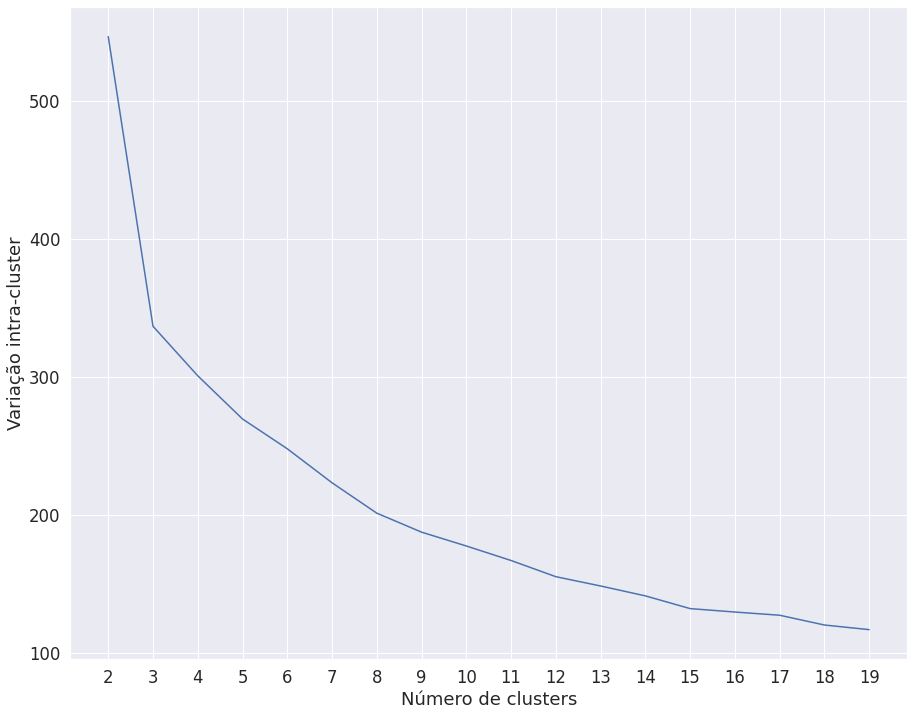

In [ ]:
variance_intra_cluster = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(normalized_df)
    variance_intra_cluster.append(kmeans.inertia_)

plt.figure(figsize=(15, 12))
sns.set(font_scale=1.5)
sns.lineplot(x=list(range(2, 20)), y=variance_intra_cluster)
plt.xticks(list(range(2, 20)))
plt.xlabel('Número de clusters')
plt.ylabel('Variação intra-cluster')

* Através do método do cotovelo podemos encontrar o número de k ideal como sendo 3

In [ ]:
kmeans = KMeans(n_clusters=3, max_iter=99999)
final_df['cluster'] = kmeans.fit_predict(normalized_df)

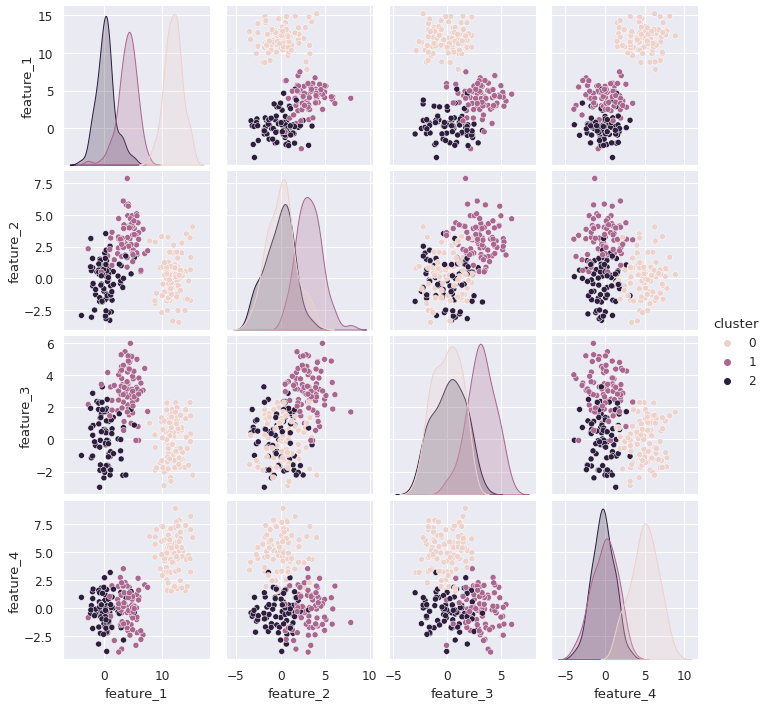

In [ ]:
sns.set(font_scale=1.1)
sns.pairplot(final_df, hue='cluster')

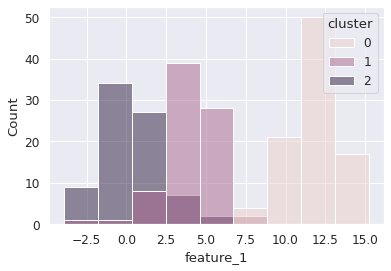

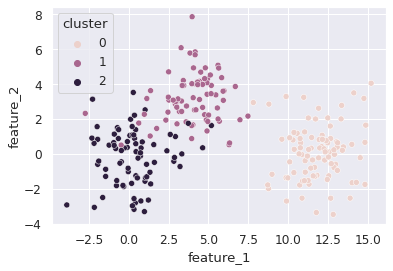

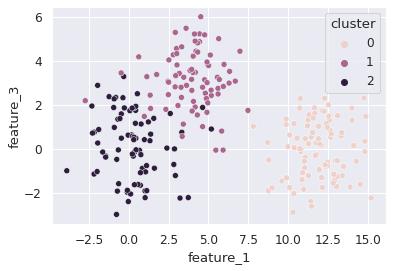

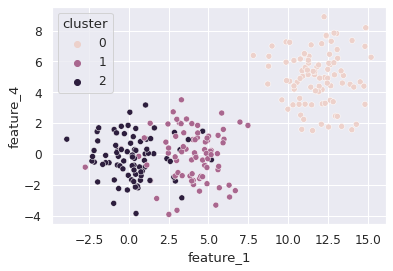

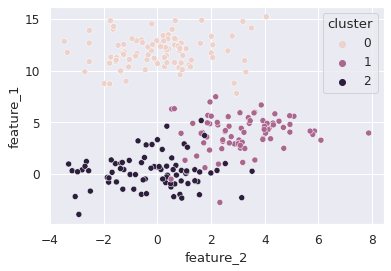

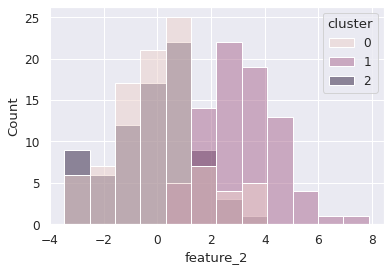

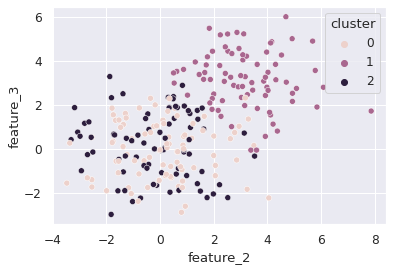

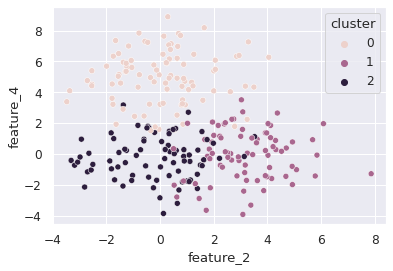

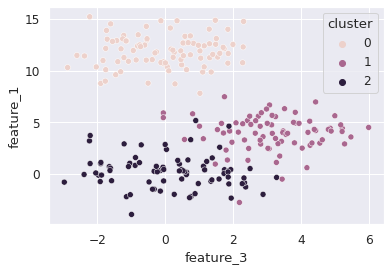

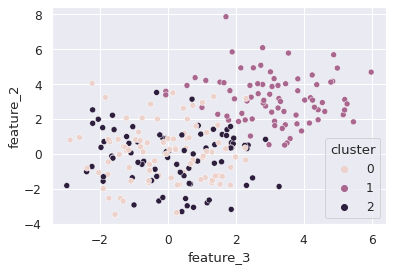

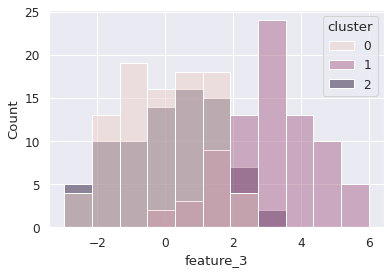

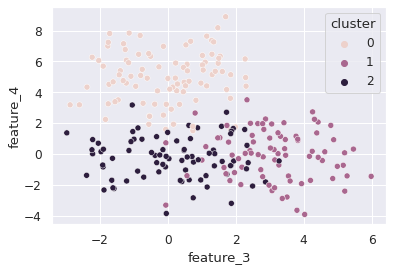

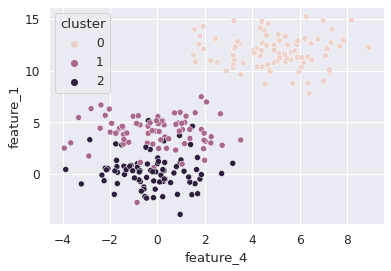

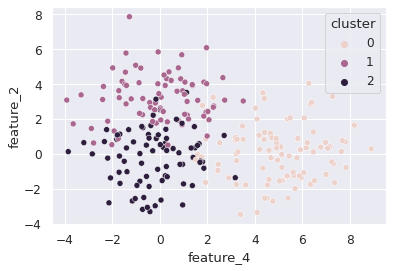

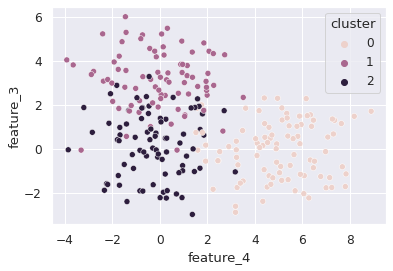

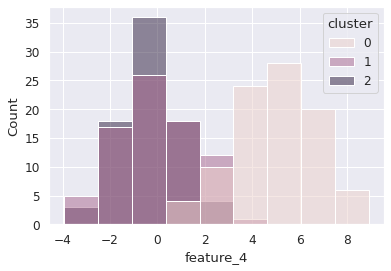

In [ ]:
for f_1 in final_df.columns.drop('cluster'):
    for f_2 in final_df.columns.drop('cluster'):
        if(f_1 != f_2):
            sns.scatterplot(data=final_df, x=f_1, y=f_2, hue='cluster')
        else:
            sns.histplot(data=final_df, x=f_1, hue='cluster')
        plt.savefig(f'imagens/{f_1}-{f_2}.png')
        plt.show()

### 5 - Aplicação do PCA

In [ ]:
pca = PCA()
pca.fit(df_exemplo)

PCA()

In [ ]:
pca_df = pd.DataFrame(pca.transform(df_exemplo), columns=pca.get_feature_names_out())

In [ ]:
pca_df

,pca0,pca1,pca2,pca3
0,9.014663,2.944879,2.240968,0.003442
1,7.143919,1.497167,-0.787538,-2.562291
2,9.503065,1.593300,-2.047818,1.245970
3,-8.559746,-0.025423,-0.011227,-1.225016
4,9.022529,0.599978,3.284294,-0.947608
...,...,...,...,...
245,7.613861,3.496610,3.115986,-0.520428
246,-3.612794,-2.081878,0.707301,2.523676
247,7.436250,0.928103,1.066544,-1.610851
248,1.490525,-1.672661,0.104781,0.160735


In [ ]:
pca_df['cluster'] = final_df['cluster']

<AxesSubplot:xlabel='pca0', ylabel='pca1'>

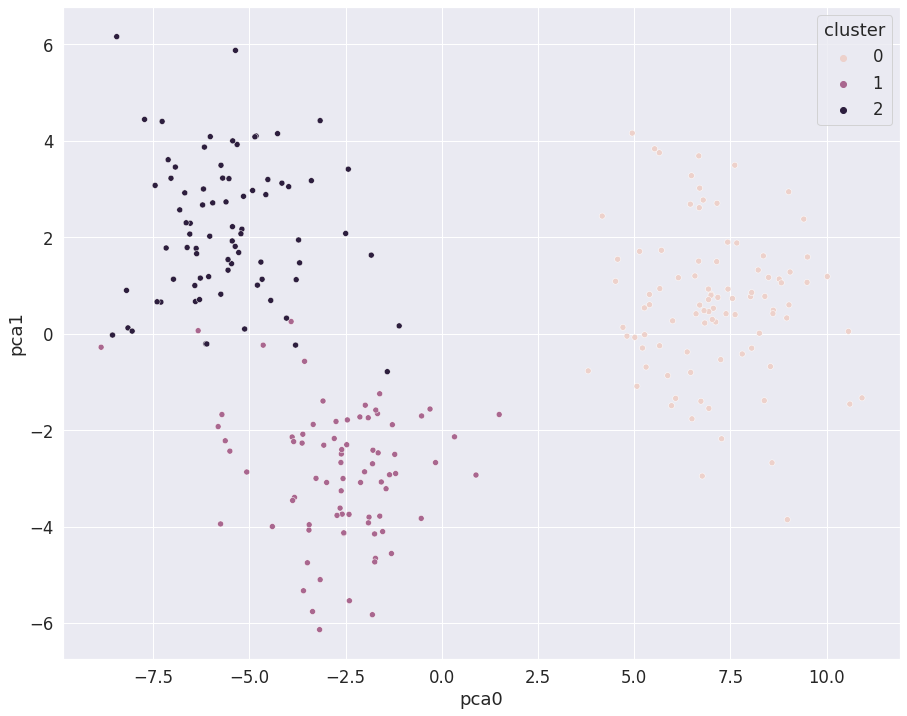

In [ ]:
plt.figure(figsize=(15, 12))
sns.set(font_scale=1.5)
sns.scatterplot(data=pca_df, x='pca0', y='pca1', hue='cluster')

In [ ]:
px.scatter_3d(pca_df, x='pca0', y='pca1', z='pca2', color='cluster', width=1000, height=800)

In [ ]:
correlation = {}
for column_normalized in normalized_df.columns:
    correlation[column_normalized] = []
    for column_pca in pca_df.columns.drop('cluster'):
        correlation[column_normalized].append(pca_df[column_pca].corr(normalized_df[column_normalized]))
correlation = pd.DataFrame(correlation, index=pca_df.columns.drop('cluster'))

<AxesSubplot:>

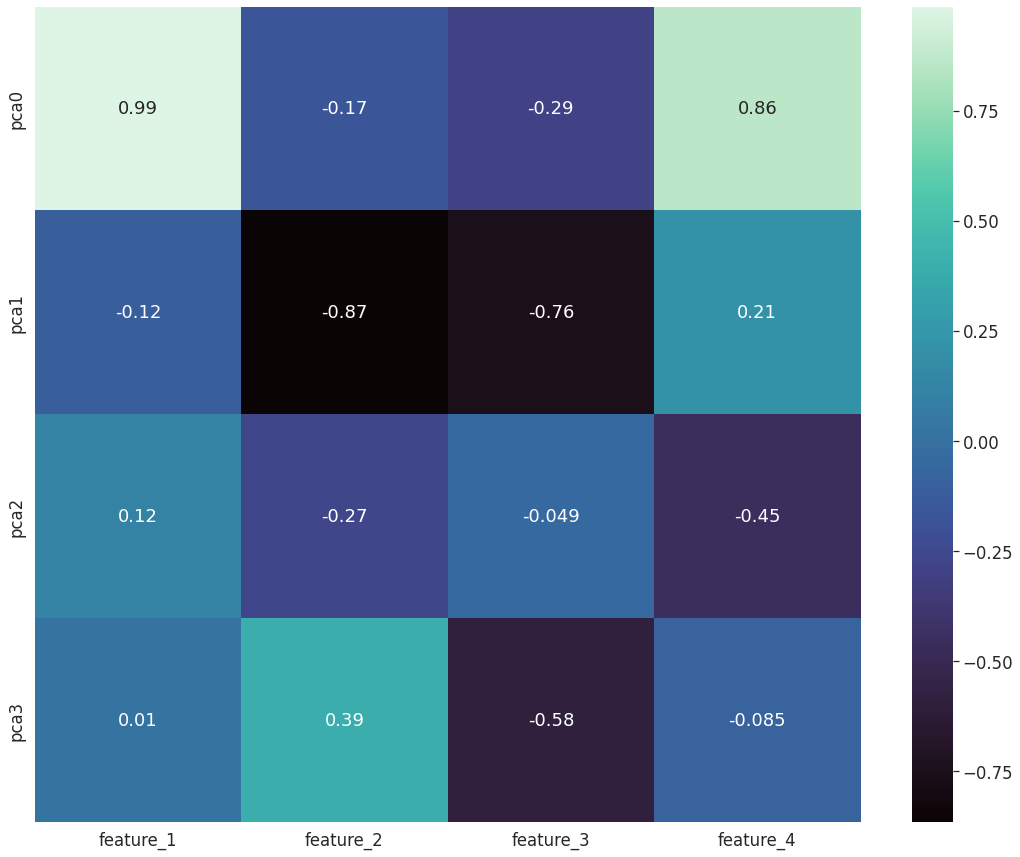

In [ ]:
plt.figure(figsize=(18.5, 15))
sns.set(font_scale=1.5)
sns.heatmap(correlation, annot=True, cmap='mako')

Text(0, 0.5, 'Variância explicada (%)')

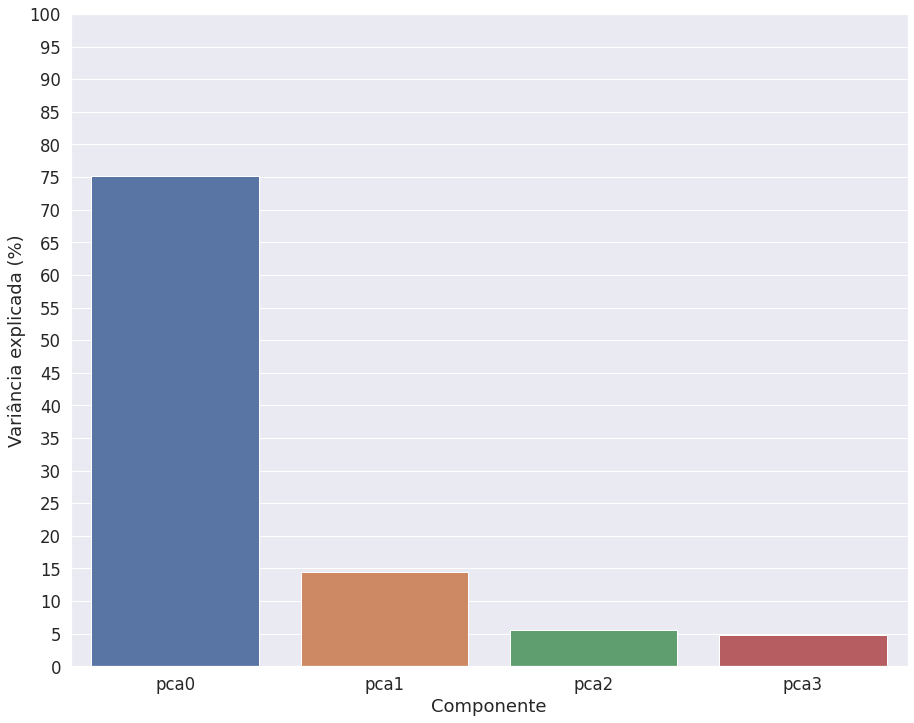

In [ ]:
plt.figure(figsize=(15, 12))
sns.set(font_scale=1.5)
sns.barplot(x=pca.get_feature_names_out(), y=pca.explained_variance_ratio_*100)
plt.yticks([x for x in np.arange(0, 100+1, 5)])
plt.xlabel('Componente')
plt.ylabel('Variância explicada (%)')